In [89]:
import sys  
sys.path.insert(0, '../')

In [128]:
import torch
from libs.curve_rays import CurveModel
from libs.other_helpers import unit_vector, random_on_unit_sphere
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
ckpt_path = '../logs/spheres_generated_curved/130000.tar'

In [108]:
near = 2.
far = 20.
N_samples = 20
N_rays = 500

In [109]:
model = CurveModel()

In [110]:
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['curver'])

<All keys matched successfully>

In [111]:
rays_o = random_on_unit_sphere((N_rays, 3)) * 4
rays_d = -1 * torch.rand((N_rays, 3)) + 1 # This is distributed -1 to 1
rays_d = unit_vector(rays_d)

t_vals = torch.linspace(0., 1., steps=N_samples)
z_vals = near * (1. - t_vals) + far * t_vals
z_vals = z_vals.expand([N_rays, N_samples])
target = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  # [N_rays, N_samples, 3]

input_batch = torch.cat((rays_o, rays_d), dim=-1).unsqueeze(1)
input_batch = input_batch.expand(N_rays, N_samples, 6)
input_batch = torch.cat((input_batch, z_vals.unsqueeze(-1)), dim=-1)

In [112]:
input_batch.shape

torch.Size([500, 20, 7])

In [113]:
o = model(input_batch)

In [114]:
o = o.detach().cpu().numpy()

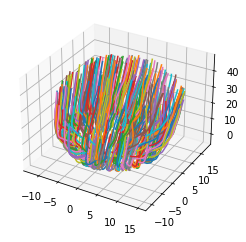

In [130]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in o:
    ax.plot(i[:, 0], i[:, 1], i[:, 2])
plt.show()